In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight

from Models import Models, PretrainedModelLetters

In [2]:
import random

random.seed(10)

# Carga de datos

In [3]:
train_data = pd.read_csv("data/train_letters.csv")
test_data = pd.read_csv("data/validation_letters.csv")

In [4]:
train_data.head()

,sequence_id,target,file
0,1,a,a (1) 2.png
1,2,a,a (1) 3.png
2,3,a,a (1).png
3,4,a,a (10) 2.png
4,5,a,a (10) 3.png


# Analisis Exploratorio

In [5]:
print("--------------------Train data--------------------")
print(f"Cantidad de filas : {train_data.shape[0]}")
train_letters = list(train_data.target.unique())
train_letters.sort()
print(f"Frases unicas : {train_letters}")

--------------------Train data--------------------
Cantidad de filas : 1813
Frases unicas : ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'ñ']


In [6]:
print("--------------------Validation data--------------------")
print(f"Cantidad de filas : {test_data.shape[0]}")
val_letters = list(test_data.target.unique())
val_letters.sort()
print(f"Frases unicas : {val_letters}")

--------------------Validation data--------------------
Cantidad de filas : 204
Frases unicas : ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'ñ']


In [7]:
if (train_letters != val_letters):
    raise ValueError("Error between target and train")

In [8]:
train_data.describe()

,sequence_id
count,1813.000000
mean,648.377827
std,253.865470
min,1.000000
25%,493.000000
50%,805.000000
75%,820.000000
max,835.000000


# Preprocesamiento del Modelo

Solo se obtienen 20 indices de las coordenadas x y y, ya que son las unicas que han sido altamente entrenadas del modelo mediapipe de Google

In [9]:
def get_needed_cols():
    cols = []

    for i in range(21):
        cols.append(f'x_Right_hand_{i}')
        cols.append(f'y_Right_hand_{i}')
        cols.append(f'x_Left_hand_{i}')
        cols.append(f'y_Left_hand_{i}')
    
    return cols

In [10]:
df = pd.read_csv("data/data_letters.csv")
df_test = df[df['sequence_id'].isin(test_data['sequence_id'])]
df_train = df[df['sequence_id'].isin(train_data['sequence_id'])]

In [11]:
# Count the occurrences of each ID
id_counts = test_data['sequence_id'].value_counts()

# Separate IDs repeated many times and those repeated once
many_times_repeated_ids = id_counts[id_counts > 1].index
once_repeated_ids = id_counts[id_counts == 1].index

df_test = df[df['sequence_id'].isin(once_repeated_ids)]
df_test_repeated = df[df['sequence_id'].isin(many_times_repeated_ids)]

In [12]:
# Count the occurrences of each ID
id_counts = train_data['sequence_id'].value_counts()

# Separate IDs repeated many times and those repeated once
many_times_repeated_ids = id_counts[id_counts > 1].index
once_repeated_ids = id_counts[id_counts == 1].index

df_train = df[df['sequence_id'].isin(once_repeated_ids)]
df_train_repeated = df[df['sequence_id'].isin(many_times_repeated_ids)]

In [13]:
df.head()

,sequence_id,target,x_Left_hand_0,y_Left_hand_0,x_Left_hand_1,y_Left_hand_1,x_Left_hand_2,y_Left_hand_2,x_Left_hand_3,y_Left_hand_3,...,x_Right_hand_16,y_Right_hand_16,x_Right_hand_17,y_Right_hand_17,x_Right_hand_18,y_Right_hand_18,x_Right_hand_19,y_Right_hand_19,x_Right_hand_20,y_Right_hand_20
0,1,a,0.000000,0.048423,0.064452,0.326796,0.334537,0.619979,0.491786,0.815735,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,a,0.000000,0.168434,0.215612,0.370625,0.470939,0.601284,0.569410,0.799514,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,a,0.423459,0.140339,0.655401,0.363291,0.737979,0.605570,0.726230,0.804285,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,a,0.204003,0.300461,0.476328,0.473332,0.767077,0.663757,0.826010,0.838651,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,a,0.920469,0.121714,0.639250,0.352007,0.432306,0.607345,0.365829,0.815395,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
print(len(df))
print(len(df_test) == len(test_data))
print(len(df_train) == len(train_data))

2017
False
False


# Modelo

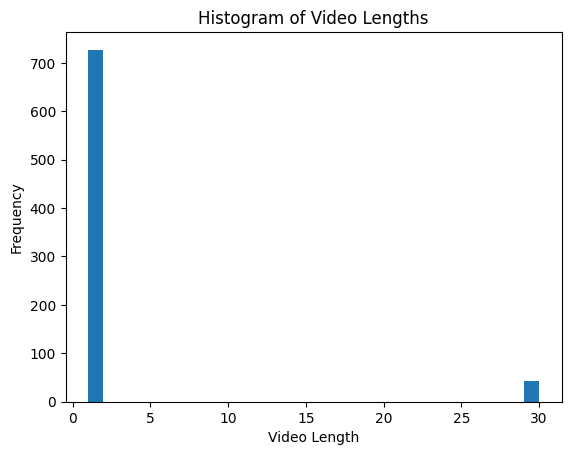

In [15]:
# Compute the lengths of the video sequences
video_lengths = df.groupby('sequence_id').size()
max_seq_length = video_lengths.max()
# max_seq_length = 30
# Plot the histogram
plt.hist(video_lengths, bins=30)  # Adjust the number of bins as needed
plt.xlabel('Video Length')
plt.ylabel('Frequency')
plt.title('Histogram of Video Lengths')
plt.show()

In [16]:
video_lengths.max()

30

In [17]:
# Create a one-hot encoder
label_encoder = LabelEncoder()

In [18]:
def padding_labels(target):
    integer_encoded = label_encoder.fit_transform(target)
    integer_encoded = integer_encoded.reshape(-1, 1)

    # Encode the word "Hello"
    onehot_encoder = OneHotEncoder(sparse=False)  # sparse=False to get a numpy array as output
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    return onehot_encoded

In [19]:
target_train = df_train['target'][df_train.groupby('sequence_id').cumcount() == 0].tolist()

In [20]:
X_train = df_train

In [21]:
del X_train["sequence_id"] 
del X_train["target"] 

In [22]:
target_test = df_test['target'][df_test.groupby('sequence_id').cumcount() == 0].tolist()

In [23]:
X_test = df_test

In [24]:
del X_test["sequence_id"] 
del X_test["target"] 

In [25]:
models = Models(max_seq_length=30)

X_train_repeated_flat = models.get_flat_X(df_train_repeated)
X_train_repeated_flat = pd.DataFrame(df_train_repeated)
# X_train_repeated_flat[["sequence_id", "target"]]

target_train_repeated = X_train_repeated_flat["target"][X_train_repeated_flat.groupby("sequence_id").cumcount() == 0].tolist()

del X_train_repeated_flat["sequence_id"] 
del X_train_repeated_flat["target"]

len(target_train_repeated)

37

In [26]:
models = Models(max_seq_length=30)
X_test_repeated_flat = models.get_flat_X(df_test_repeated)

X_test_repeated_flat = pd.DataFrame(df_test_repeated)
# X_train_repeated_flat[["sequence_id", "target"]]

target_test_repeated = X_test_repeated_flat["target"][X_test_repeated_flat.groupby("sequence_id").cumcount() == 0].tolist()

del X_test_repeated_flat["sequence_id"] 
del X_test_repeated_flat["target"]

len(target_test_repeated)

6

In [27]:
del df_train_repeated["sequence_id"]
del df_train_repeated["target"]

In [28]:
del df_test_repeated["sequence_id"]
del df_test_repeated["target"]

In [29]:
models = Models(max_seq_length=30)

X_train_repeated_flat = models.get_flat_X(df_train_repeated)
X_test_repeated_flat = models.get_flat_X(df_test_repeated)

X_train_repeated_flat = pd.DataFrame(X_train_repeated_flat)
X_test_repeated_flat = pd.DataFrame(X_test_repeated_flat)

len(X_train_repeated_flat), len(X_test_repeated_flat)

(37, 6)

In [30]:
target_train = target_train + target_train_repeated

In [31]:
target_test = target_test + target_test_repeated

In [32]:
y_train = padding_labels(target_train)
y_test = padding_labels(target_test)

In [33]:
models = Models(max_seq_length=1)

In [34]:
X_train_flat = models.get_flat_X(X_train)
X_test_flat = models.get_flat_X(X_test)

In [35]:
# Concatenate vertically
result_df = pd.concat([pd.DataFrame(X_test_flat), X_test_repeated_flat], axis=0, ignore_index=True)
result_df = result_df.fillna(0)
X_test_flat = models.get_flat_X(result_df)

In [36]:
len(X_test_flat), len(target_test)

(30, 30)

In [37]:
# Concatenate vertically
result_df = pd.concat([pd.DataFrame(X_train_flat), X_train_repeated_flat], axis=0, ignore_index=True)
result_df = result_df.fillna(0)
X_train_flat = models.get_flat_X(result_df)

In [38]:
len(X_train_flat), len(target_train)

(740, 740)

# Modelo
La entrada son las coordenadas de la mano que están relacionados en totalidad con la letra (target).
Es un tipo de GLM donde se asume que la distribusión es Gauseana normal. 
No necesita de epocas porque aprende cual es la mejor ecuacion para minimizar el error de predicción.

In [40]:
class_weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(target_train),
                                        y = target_train                                                    
                                    )
class_weights = dict(zip(np.unique(target_train), class_weights))

In [41]:
# Create an AdaBoost classifier with a base model (e.g., DecisionTreeClassifier)
base_model = DecisionTreeClassifier(max_depth=len(train_letters) - 1, min_samples_split=4, min_samples_leaf=4, class_weight=class_weights)
decision_tree = AdaBoostClassifier(base_model, n_estimators=50, random_state=42)

# Fit the ensemble model
decision_tree.fit(X_train_flat, target_train)

# Make predictions
y_pred_tree = decision_tree.predict(X_test_flat)

# Calculate the accuracy score on a test dataset
accuracy_tree = decision_tree.score(X_test_flat, target_test)

# Print the accuracy
print(f'Accuracy: {accuracy_tree:.2f}')

Accuracy: 0.93


# Guardando el modelo

In [42]:
models.save_model("label_encoder_letters", label_encoder)
models.save_model("tree_letters", decision_tree)

In [43]:
correct = 0
for i in range(len(y_pred_tree)):
    if (target_test[i] == y_pred_tree[i]):
        correct += 1
        print("Correctamente predicha: ", y_pred_tree[i])
    else:
        print(">>> LOG INCORRECTA: ")
        print("            TREE: ", y_pred_tree[i])
        print("            Correcto: ", target_test[i])

Correctamente predicha:  a
Correctamente predicha:  b
Correctamente predicha:  c
Correctamente predicha:  d
>>> LOG INCORRECTA: 
            TREE:  o
            Correcto:  e
Correctamente predicha:  g
Correctamente predicha:  h
Correctamente predicha:  i
Correctamente predicha:  k
Correctamente predicha:  l
Correctamente predicha:  m
Correctamente predicha:  n
Correctamente predicha:  o
Correctamente predicha:  p
>>> LOG INCORRECTA: 
            TREE:  z
            Correcto:  q
Correctamente predicha:  r
Correctamente predicha:  t
Correctamente predicha:  u
Correctamente predicha:  v
Correctamente predicha:  w
Correctamente predicha:  x
Correctamente predicha:  y
Correctamente predicha:  z
Correctamente predicha:  ñ
Correctamente predicha:  j
Correctamente predicha:  f
Correctamente predicha:  f
Correctamente predicha:  j
Correctamente predicha:  s
Correctamente predicha:  s


In [44]:
print("Correct >> ", correct)
print("Expected >> ", len(y_pred_tree))
print("Ratio >> ", str(correct/len(y_pred_tree)))

Correct >>  28
Expected >>  30
Ratio >>  0.9333333333333333


# Reutilizando el modelo

In [45]:
load_test_data = pd.read_csv("data/data_test_hola.csv", usecols=get_needed_cols())
load_test_data.head()


# Add 70 new columns (Column31, Column32, ..., Column100)
for i in range(0, 29 * 84):
    load_test_data['Column_{}'.format(i)] = 0

/var/folders/6q/4k8kv9b92kq3hl1_hgclry4m0000gn/T/ipykernel_5586/1407918311.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  load_test_data['Column_{}'.format(i)] = 0
/var/folders/6q/4k8kv9b92kq3hl1_hgclry4m0000gn/T/ipykernel_5586/1407918311.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  load_test_data['Column_{}'.format(i)] = 0
/var/folders/6q/4k8kv9b92kq3hl1_hgclry4m0000gn/T/ipykernel_5586/1407918311.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many time

In [46]:
pretainedModels = PretrainedModelLetters()
results = pretainedModels.get_predictions(load_test_data)

/Users/andreaamaya/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(


In [47]:
results

array(['h', 'o', 'l', 'a'], dtype='<U1')

In [48]:
"".join(results)

'hola'